## Essencial Functions and Libraries

In [1]:
import torch
import os
import tifffile as tiff
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
import torch.optim as optim
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import matplotlib.pyplot as plt

NUM_CLASSES = 3  
SPLIT_TRAIN_TEST = 0.8  # 80% train, 20% test  
SPLIT_TRAIN_VAL = 0.2 # 80% train, 20% validation
BATCH_SIZE = 8  # Batch size for DataLoader
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BeetsSegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks
       
        self.mean = np.mean(images, axis=(0, 1, 2))
        self.std = np.std(images, axis=(0, 1, 2))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # (H, W, C)
        mask = self.masks[idx]  # (H, W)

        img = (img - self.mean) / (self.std + 1e-8)

        img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        if not torch.is_tensor(mask):
            mask = torch.from_numpy(mask)

        return img_tensor, mask

def get_deeplabv3_model(num_classes):
    model = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
    # Get the original conv1 layer
    orig_conv = model.backbone.conv1
    new_conv = torch.nn.Conv2d(
        in_channels=4,
        out_channels=orig_conv.out_channels,
        kernel_size=orig_conv.kernel_size,
        stride=orig_conv.stride,
        padding=orig_conv.padding,
        bias=orig_conv.bias is not None
    )
    with torch.no_grad():
        new_conv.weight[:, :3] = orig_conv.weight  # Copy RGB weights
        new_conv.weight[:, 3] = orig_conv.weight[:, 0]  # Initialize 4th channel
        model.backbone.conv1 = new_conv
        # Update classifier for your number of classes
        model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)
        return model

## Prepare Dataset

### Read data

In [ ]:
dataset_dir = 'spotlite_dataset_loca1_date1_dir1'

images_dataset_dir = os.path.join(dataset_dir, 'images')
masks_dataset_dir = os.path.join(dataset_dir, 'masks')

# Verify if directories exist (optional, but recommended)
assert os.path.exists(images_dataset_dir), f"Images directory not found: {images_dataset_dir}"
assert os.path.exists(masks_dataset_dir), f"Masks directory not found: {masks_dataset_dir}"

image_files = sorted(os.listdir(images_dataset_dir))
mask_files = sorted(os.listdir(masks_dataset_dir))

imgs, masks = [], []

# Check if the number of files match
assert len(image_files) == len(mask_files), "Number of images and masks don't match."

for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(images_dataset_dir, image_file)
    mask_path = os.path.join(masks_dataset_dir, mask_file)

    read_img = tiff.imread(image_path)
    read_mask = tiff.imread(mask_path)

    imgs.append(read_img)
    masks.append(read_mask)

imgs = np.stack(imgs)   # (N, H, W, C)
masks = np.stack(masks) # (N, H, W)

print(f'shape of imgs: {imgs.shape}')
print(f'shape of masks: {masks.shape}')

### Convert labels in masks

In [ ]:
# Convert labels in masks from 0, 3, 4 to 0, 1, 2
# where 0 is background, 1 is class 1, and 2 is class
def remap_mask(mask):
    if not torch.is_tensor(mask):
        mask = torch.from_numpy(mask)
    remapped = torch.zeros_like(mask)
    remapped[mask == 0] = 0
    remapped[mask == 3] = 1
    remapped[mask == 4] = 2
    return remapped.long()

masks = remap_mask(masks)

### Obtain Dataloaders

In [ ]:
full_dataset = BeetsSegmentationDataset(imgs, masks)

train_size = int(SPLIT_TRAIN_TEST * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset_raw, test_dataset = random_split(full_dataset, [train_size, test_size])

val_size = int(SPLIT_TRAIN_VAL * len(train_dataset_raw))
real_train_size = len(train_dataset_raw) - val_size
train_dataset, val_dataset = random_split(train_dataset_raw, [real_train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for imgs_i, masks_i in train_loader:
    print("Train Images:", imgs_i.shape)
    break

for imgs_i, masks_i in val_loader:
    print("Val Images:", imgs_i.shape)
    break

### Save Dataloaders

In [ ]:
def save_dataloaders(train_loader, val_loader, test_loader, filename='dataloaders.pth'):
    dataloaders = {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader
    }
    torch.save(dataloaders, filename)
    print(f"Dataloaders saved to {filename}")

save_dataloaders(train_loader, val_loader, test_loader)

## Train model

### Load model and dataloaders

In [ ]:
model = get_deeplabv3_model(NUM_CLASSES)

dataloaders = torch.load('dataloaders.pth')
train_loader = dataloaders['train_loader']
val_loader = dataloaders['val_loader']

### Train DeepLabV3 model

In [ ]:
def train_deeplabv3(model, train_loader, val_loader, num_epochs=100, lr=1e-4, device='cuda', patience=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        # -------------------
        # Training
        # -------------------
        model.train()
        running_train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")

        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)
            progress_bar.set_postfix({"train_loss": f"{loss.item():.4f}"})

        epoch_train_loss = running_train_loss / len(train_loader.dataset)

        # -------------------
        # Validation
        # -------------------
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device).long()

                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                running_val_loss += loss.item() * images.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # -------------------
        # Early stopping
        # -------------------
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # -------------------
    # Salve the best model
    # -------------------
    if best_model_state is not None:
        torch.save(best_model_state, 'best_deeplabv3_model.pth')
        print("Best model saved with validation loss:", best_val_loss)

    print("Training complete.")

train_deeplabv3(model, train_loader, val_loader, num_epochs=100, lr=1e-4, device=DEVICE, patience=10)

## Test model

### Load  model and dataloaders

In [4]:
model = get_deeplabv3_model(NUM_CLASSES)
model.load_state_dict(torch.load('best_deeplabv3_model.pth'))
model = model.to(DEVICE)
model.eval()

dataloaders = torch.load('dataloaders.pth')
test_loader = dataloaders['test_loader']

/tmp/ipykernel_394127/1401991351.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_deeplabv3_model.pth'))
/tmp/ipykernel_394127/1401

### Calculate Metrics

0-Background - Average Precision: 0.9908
1-Pinus - Average Precision: 0.0808
2-Eucalyptus - Average Precision: 0.7450

Mean Average Precision (mAP): 0.6055


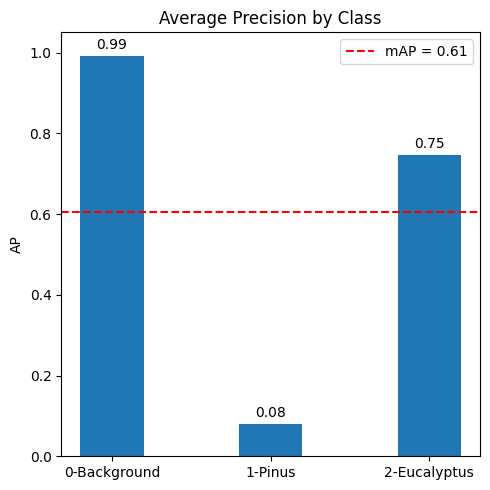

In [ ]:
from sklearn.metrics import average_precision_score
import numpy as np
import torch

class_names = ['0-Background', '1-Pinus', '2-Eucalyptus']

def compute_average_precision_per_class(model, dataloader, num_classes, device='cuda'):
    model.eval()
    all_labels = [[] for _ in range(num_classes)]
    all_probs = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).long()
            outputs = model(images)['out']
            probs = torch.softmax(outputs, dim=1).cpu()
            masks = masks.cpu()

            for c in range(num_classes):
                true_c = (masks == c).float().reshape(-1).numpy()
                prob_c = probs[:, c, :, :].reshape(-1).numpy()
                all_labels[c].extend(true_c)
                all_probs[c].extend(prob_c)

    ap_per_class = []
    for c in range(num_classes):
        if len(np.unique(all_labels[c])) < 2:
            ap = float('nan') 
        else:
            ap = average_precision_score(all_labels[c], all_probs[c])
        ap_per_class.append(ap)

    mean_ap = np.nanmean(ap_per_class)
    return ap_per_class, mean_ap

ap_per_class, mean_ap = compute_average_precision_per_class(model, test_loader, num_classes=3, device='cuda')

for name, ap in zip(class_names, ap_per_class):
    print(f"{name} - Average Precision: {ap:.4f}")
print(f"\nMean Average Precision (mAP): {mean_ap:.4f}")

plt.figure(figsize=(5, 5))
bars = plt.bar(class_names, ap_per_class, width=0.4)

for bar, ap in zip(bars, ap_per_class):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{ap:.2f}', ha='center', va='bottom')

plt.ylim(0, 1.05)
plt.axhline(mean_ap, color='red', linestyle='--', label=f'mAP = {mean_ap:.2f}')
plt.title('Average Precision by Class')
plt.ylabel('AP')
plt.legend()
plt.tight_layout()
plt.show()

## Imprecise Probability

### Obtain likelihoods

In [18]:
model = get_deeplabv3_model(NUM_CLASSES)
model.load_state_dict(torch.load('best_deeplabv3_model.pth'))
model = model.to(DEVICE)
model.eval()

dataloaders = torch.load('dataloaders.pth')
train_loader = dataloaders['train_loader']
val_loader = dataloaders['val_loader']
test_loader = dataloaders['test_loader']

def get_likelihoods(model, loader):
    all_likelihoods = []
    all_masks = []
    with torch.no_grad():
        for images, mask in loader:
            images = images.to(DEVICE)
            mask = mask.to(DEVICE).long()
            outputs = model(images)['out']
            likelihoods = torch.softmax(outputs, dim=1).cpu()
            all_likelihoods.append(likelihoods)
            all_masks.append(mask.cpu())
    
    return torch.cat(all_likelihoods, dim=0), torch.cat(all_masks, dim=0)

train_likelihoods, train_labels = get_likelihoods(model, train_loader)
val_likelihoods, val_labels = get_likelihoods(model, val_loader)
test_likelihoods, test_labels = get_likelihoods(model, test_loader)

print(f"Train likelihoods and masks shape: {train_likelihoods.shape} | {train_labels.shape}")
print(f"Validation likelihoods and masks shape: {val_likelihoods.shape} | {val_labels.shape}")
print(f"Test likelihoods and masks shape: {test_likelihoods.shape} | {test_labels.shape}")

/tmp/ipykernel_428223/1508212436.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_deeplabv3_model.pth'))
/tmp/ipykernel_428223/1508

Train likelihoods and masks shape: torch.Size([122, 3, 512, 512]) | torch.Size([122, 512, 512])
Validation likelihoods and masks shape: torch.Size([30, 3, 512, 512]) | torch.Size([30, 512, 512])
Test likelihoods and masks shape: torch.Size([39, 3, 512, 512]) | torch.Size([39, 512, 512])


### Obtain lower bounds

In [ ]:
def obtain_lower_bound(probs, alpha=0.1, eps=1e-6):

    entropy = -torch.sum(probs * torch.log(probs + eps), dim=1)  # (N, H, W)
    lower_bound = (probs - alpha * entropy.unsqueeze(1)).clamp(0, 1)       # (N, C, H, W)

    return lower_bound

val_lower_bound = obtain_lower_bound(val_likelihoods, alpha=0.1)
test_lower_bound = obtain_lower_bound(test_likelihoods, alpha=0.1)

print(f"Validation lower bound shape: {val_lower_bound.shape}")
print(f"Test lower bound shape: {test_lower_bound.shape}")

Validation lower bound shape: torch.Size([30, 3, 512, 512])
Test lower bound shape: torch.Size([39, 3, 512, 512])


### Visualize distribution of likelyhood by class

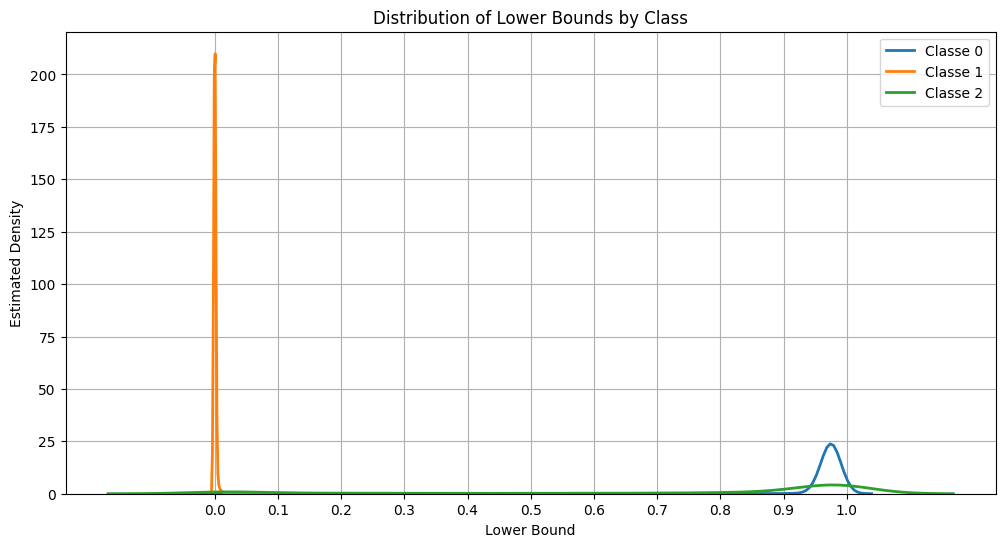

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_lower_bound_distribution(lower_bound, labels, sample_size=10000):
    
    N, C, H, W = lower_bound.shape

    plt.figure(figsize=(12, 6))

    for c in range(C):
        mask = (labels == c).unsqueeze(1)  # shape: (N, 1, H, W)
        lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

        if lower_c.numel() > sample_size:
            indices = torch.randperm(lower_c.numel())[:sample_size]
            lower_c = lower_c[indices]

        sns.kdeplot(lower_c.cpu().numpy(), label=f'Classe {c}', linewidth=2)

    plt.title("Distribution of Lower Bounds by Class")
    plt.xlabel("Lower Bound")
    plt.ylabel("Estimated Density")
    plt.legend()
    plt.xticks(np.arange(0, 1.1, 0.1)) 
    plt.grid(True)
    plt.show()

plot_lower_bound_distribution(val_lower_bound, val_labels)